# 11. 空間構造のある階層ベイズモデル

* これまでの章で場所差(植木鉢差）を組み込んだ統計モデルを作っていたが、場所差はそれぞれ独立に決まることを前提としており、「空間構造」はないもの、考えなくて良いものとしてきた。
* しかし現実では、「データを取る場所の空間配置の影響」を無視できない場合もある。
* この章では、場所差の空間相関も考慮する統計モデリングについて説明する。
    * 空間相関とは距離の遠近に依存して、二つの場所の「類似性」みたいなものが弱くなったり、強くなったりする傾向。

## 11.1. 例題：1次元空間上の個体数分布

### 例題

* 調査区画を50個設定。それが1本の直線の上に等間隔に配置されている。(一次元)
* その区画での生物の個体数を記録。
* 調査区画$j$で観察された個体数$y_j$は図11.2で記録。
* 架空データ{$y_j$}は場所$j$ごとに平均の異なるポアソン乱数として発生させたものであり、その平均は図11.2の破線の曲線(局所密度)。
* 局所密度は何らかの理由でなだらかに変化しており、近くにある$y_j$同士は近い値(空間相関)
* 図11.2の白丸を与えられれば、局所密度が場所ごとに異なること、局所密度がなだらかに変化していること、は想像できるだろう。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan

%matplotlib inline

df = pd.read_csv("./input/Y.csv",index_col=0)

In [2]:
df.head()

,x
1,0
2,3
3,2
4,5
5,6


<Container object of 50 artists>

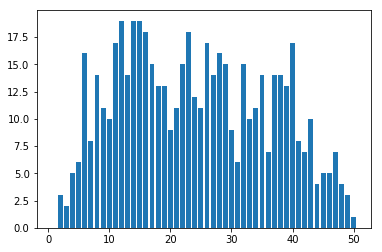

In [3]:
plt.bar(df.index,df.x)

In [4]:
df.x.mean()

10.880000000000001

In [5]:
df.x.var()

27.373061224489792

## 11.2. 階層ベイズモデルに空間構造を組み込む

### この例題の目的

* 観測データ{$y_j$}に基づいて、位置によって変化する局所密度を構成できるような統計モデルを作ること

1. 各調査区画で観測された個体数がどんな確率分布で表現できるかを考える。
    * 全ての調査区画で共通する平均値$\lambda$のポアソン分布に従うとする。
    $$
    p(y_j | \lambda) = \frac {\lambda^{y_j} exp(-\lambda)} {y_j!}
    $$
2. 上記で仮定するなら平均値$\lambda$は標本平均と等しいとして良い。また、ポアソン分布の分散は平均と等しい。
3. すると、平均10.9に対し、分散27.4となり、標本平均の3倍ほど。このデータは過分散であるとわかる。また、図11.2では個体数$y_j$が位置によって変化しており、「$\lambda$はどの$j$でも同じ」という仮定も成立していないよう。単純にポアソン分布では統計モデル化できない。
4.　何らかの形で場所差を組み込む。区間$j$ごとに平均$\lambda_j$が異なるとする。
5. しかし区画ごとにパラメータを最尤推定するのは、単なる「データの読み上げ」と同じ。
6. そこで全体に共通する大域的な密度と、局所的な差異を同時に組み込むために、平均個体数$\lambda_j$を線形予測しと対数リンク関数を使って、以下のように表す。
$$
\log \lambda_j = \beta + r_j
$$
    * 切片$\beta$は大域的なパラメータ。全ての場所に同じ影響
    * 場所差$r_j$は局所的。区間$j$のデータだけを説明する。
7. $\beta$のような大域的なパラメータの事前分布には無情報事前分布、{$r_j$}の事前分布には階層事前分布を指定する。

### 11.2.1. 空間構造のない階層事前分布

* 10章で使ったような階層事前分布(下記)では、どれも独立に同じ事前分布(平均ゼロ、標準偏差$s$の正規分布を仮定してることになり、空間相関がありそうな状況には適さない。
$$
p(r_j|s)= \frac {1} {\sqrt {2 \pi s^2}} \exp \left(-\frac {r_j^2}{2s^2}\right)
$$

### 11.2.2. 空間構造のある階層事前分布

#### 仮定をもうけ簡単にする

* 区間の場所差は「近傍」区画の場所差にしか影響されない
* 区画$j$の近傍の個数$n_j$は有限個であり、どの区画が近傍であるかはモデル設計者が指定
    * すぐ隣の区画のみが近傍とする。($n_j$は2)
    * 左右の両端では近傍区間は一つなので、$n_1$と$n_{50}$は1
* 近傍の直接の影響はどれも等しく,$1/n_j$

#### 上記の仮定に基いて事前分布の設定

* 上記の仮定に基づき、$r_j$の条件付き事前分布を以下のような正規分布とする。
    * 標準偏差は$\frac {s}{\sqrt{n_j}}$であると指定。
        * (滝沢不明) $\sqrt{n_j}$で割る理由。端のばらつきを減らす効果。
    * ばらつきのパラメータ$s$はどの場所でも同じと仮定。
$$
p(r_j | \mu_j,s) = \sqrt{ \frac {n_j}{2\pi s^2}} \exp \left\{ - \frac {(r_j - \mu_j)^2} {2s^2/n_j}\right\}
$$
* 正規分布の平均$\mu_j$は近傍である$r_{j-1}$と$r_{j+1}$の平均値に等しいとする。
    * 両端は$\mu_1=r_2,\mu_{50}=r_{49}$とする。
$$
\mu_j = \frac {r_{j-1} + r_{j+1}} {2}
$$

* このような事前分布は条件付き自己回帰モデルと呼ばれる。
    * {$r_j$}の事前分布のように様々な制約をつけて簡単にしたものは、instrinsic Gaussian CARモデルと分類される。
* この場所差{$r_j$}全体の事前分布である同時分布$p(\{r_j\}|s)$は以下のようにかける。
$$
p(\{r_j\} | s) \propto \exp \left\{ -\frac {1}{2s^2} \sum_{j \sim j'} (r_j-r_{j'})^2 \right\}
$$

## 11.3. 空間統計モデルをデータに当てはめる

#### 事後分布について考える

* 事後分布は以下のようにする
$$
p(\beta,s,\{r_j\} | {\bf Y} ) \propto p(\{r_j\} | s) p(s) p(\beta) \prod_j p(y_j|\lambda_j)
$$
* $p(y_j|\lambda_j)$は平均$\lambda_j = \exp(\beta + r_j)$のポアソン分布とした
    * 切片$\beta$は大域的なパラメータなので、事前分布は無情報事前分布
    * 場所差$r_j$は局所的なパラメータなので、事前分布は空間相関を考慮した階層事前分布で、上の式では同時分布$p(\{r_j\}| s)$で表現している。
        * 個々の条件付き事前分布$p(r_j | s)$は平均$\mu_j$,標準偏差$s/\sqrt{n_j}$の正規分布

#### Stanで書いてみる
* 作成中。。

In [49]:
model11_3 = """
data {
   int<lower=1> N_site; //区画数
   int<lower=0> Y[N_site]; //区画ごとの個体数
}

parameters {
   real beta;
   real r[N_site]; //個体差
   real<lower=0> s; //個体差のばらつき
}

generated quantities {
   real<lower=1> Y_mean[N_site];
   for (j in 1:N_site)
      Y_mean[j] = exp(beta + r[j]);
}
model { 
   beta ~ normal(0, 100);//betaの事前分布は標準偏差100の正規分布
   s ~ uniform(0,10000);// sの事前分布は0<s<10000の一様分布   

   r[1] ~ normal(r[2], s);
   for (j in 2:(N_site-1))
      r[j] ~ normal((r[j-1]+r[j+1])/2, s);
   r[50] ~ normal(r[49],s);

   for (j in 1:N_site)
      Y[j] ~ poisson_log(Y_mean[j]);
 }
 
"""

In [50]:
Y=df.x

stan_data = {"N_site":50,"Y":Y}

# MCMCサンプリングのステップ数
iter_count= 500

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
chain_count = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
warmup_count = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
thin_count = 3

fit = pystan.stan(model_code=model11_3,
                  data=stan_data,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count)

ValueError: Failed to parse Stan model 'anon_model_e78af3e7593ed3a7c792953fe70e7c0b'. Error message:
PARSER EXPECTED: whitespace to end of file.
FOUND AT line 18: 
model { 
   beta ~ normal(0, 100);//betaの事前分布は標準偏差100の正規分布
   s ~ uniform(0,10000);// sの事前分布は0<s<10000の一様分布   

   # 
   r[1] ~ normal(r[2], s);
   for (j in 2:(N_site-1))
      r[j] ~ normal((r[j-1]+r[j+1])/2, s);
   r[50] ~ normal(r[49],s);

   for (j in 1:N_site)
      Y[j] ~ poisson_log(Y_mean[j]);
 }
 





In [30]:
fit

NameError: name 'fit' is not defined

## 11.4. 空間統計モデルが作り出す確率場

* 一般に相互作用する確率変数たちで埋め尽くされた空間は確率場と呼ばれる。
    * {$r_j$}も確率場の一種。
        * (滝沢補足)$r_j$の条件付き事前分布が、平均$\mu_j = \frac {r_{j-1}+r_{j+1}} {2}$、標準偏差$s$の正規分布のため
        
* 標準偏差$s$の大きさによって、{$r_j$}の挙動をみてみる。
    * $\beta$を固定し、$s$を3パターン設定した上で、{$r_1,r_2,...,r_{50}$}の事後分布から3セットずつのサンプルを得て、$\lambda_j = \exp(\beta + r_j)$をグラフにしたのが図11.5。
    * $s$が大きいほど、隣とは無関係に値を選べるようになり、各$j$ごとに合わせようとするので、全体的にギザギザした、ばらつきの大きい確率場になる。
* このように確率場を組み込んだ統計モデルを使うことは、予測をする時の利点にもなる。

## 11.5. 空間相関モデルと欠測のある観測データ

* 空間相関を組み込んだ改装ベイズモデルの強みの一つとして「欠測のあるデータ」に対してより良い予測が得られることがあります。
* 図11.6のように、欠測データが存在する場合を考える。
* 空間相関を考慮したモデル、考慮しないモデルそれぞれによる推定を試みる。
    * 考慮しないモデルで予測された局所密度は、各区画のデータ$y_j$に合わせようとギザギザする。
    * 欠測の調査区画では平均$\lambda_j$の80%区間が大きく広がっている。
    * データがない区間では$r_j$を決めようがない。
* 現実のデータ解析ではデータを見ているだけでは空間相関は読み取れない。
    * ひとまず空間構造のあるベイズ統計モデルを当てはめて見て、その中の「隣との類似」を表すパラメーター($s$)を推定したらいいのでは。
        * $s$が大きいほど類似せず、小さいほど類似する。

## 11.6. この章のまとめ

* 空間構造のあるデータを統計モデル化する場合、空間相関を考慮しなければならない
* 空間相関のある場所差は確率場を使って表現できる。
* 空間相関を考慮した改装ベイズモデルは観測データの欠測部分を予測するような用途にも使える。
* 空間構造ではなく、時間構造のあるデータにも階層ベイズモデルをを用いることができる。

# 参考させていただいたページ
[久保緑本11章のマルコフ場モデル（空間構造のあるベイズモデル） - StatModeling Memorandum](http://statmodeling.hatenablog.com/entry/markov-field-model)